### This is Burak's implementation with some edits from my end.

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cs231n-project/daniel/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n-project/daniel


In [2]:
import numpy as np 
import cvxpy as cp
import time
import torch
import matplotlib.pyplot as plt
from torchvision import datasets

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn')
plt.rc('axes', labelsize=17)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# This notebook contains the code for the experiment in figure 11 - plots c, d of the paper
# https://arxiv.org/pdf/2101.02429.pdf
# The code implements the convex formulation for the two-layer convolutional neural network with global 
# average pooling for "binary classification" (hence, scalar output). The dataset is the fashion-mnist dataset. 
# For other details, read the explanation for figure 11 - plots c, d of the paper.

In [4]:
# load the fashion mnist dataset
# change this directory so it points to the folder where you downloaded the fashion-mnist dataset.
# directory = '/Users/bbartan/OneDrive - Stanford/research_datasets/fashion_mnist/' 
# directory = './datasets/FashionMNIST' 
# sys.path.insert(1, directory)

# X_train, y_train = load_mnist(directory, kind='train')
# X_test, y_test = load_mnist(directory, kind='t10k')

def load_Fashion_MNIST():
  train_dset = datasets.FashionMNIST('./datasets', train=True, download=True)
  test_dset = datasets.FashionMNIST('./datasets', train=False, download=True)
  X_train =  train_dset.data.numpy()
  y_train = train_dset.targets.numpy()
  X_test = test_dset.data.numpy()
  y_test = test_dset.targets.numpy()
  X_train = X_train.reshape((X_train.shape[0], -1))
  X_test = X_test.reshape((X_test.shape[0], -1))
  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_Fashion_MNIST()

train_images = X_train.astype(np.float64)
train_labels = y_train.astype(np.float64)
A = train_images.copy()
y = train_labels.copy()

inds = np.argwhere(y <= 1)[:,0] # get the first two classes
A = A[inds, :]
y = y[inds].reshape((inds.shape[0], 1))
n, d = A.shape

# test set
test_images = X_test.astype(np.float64)
test_labels = y_test.astype(np.float64)
A_test = test_images.copy()
y_test = test_labels.copy()

inds_test = np.argwhere(y_test <= 1)[:,0] # get the first two classes
A_test = A_test[inds_test, :]
y_test = y_test[inds_test].reshape((inds_test.shape[0], 1))

A = (A-128)/ 255
A_test = (A_test-128) / 255


print(A.shape, y.shape, A_test.shape, y_test.shape)

(12000, 784) (12000, 1) (2000, 784) (2000, 1)


(12000, 1, 28, 28) (2000, 1, 28, 28)


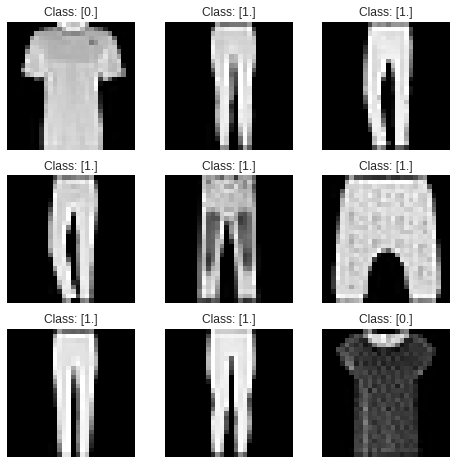

patches_train.shape: (12000, 16, 49)
0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 

In [5]:
# CNN 2D - precompute
# A_v2 = np.swapaxes(A.reshape(A.shape[0], 1, 28, 28), 2, 3)
# A_test_v2 = np.swapaxes(A_test.reshape(A_test.shape[0], 1, 28, 28), 2, 3)

A_v2 = A.reshape(A.shape[0], 1, 28, 28)
A_test_v2 = A_test.reshape(A_test.shape[0], 1, 28, 28)

print(A_v2.shape, A_test_v2.shape)
np.random.seed(0)
def visualize_dataset(X, y):
  figure = plt.figure(figsize=(8,8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(X))
    img, label = X[sample_idx], y[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Class: {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
  plt.show()
visualize_dataset(A_v2, y)

stride = 4
f = 4 # filter dimension


patches_train = torch.nn.functional.unfold(torch.tensor(A_v2), kernel_size=(f,f), stride=stride, padding=0)
patches_test = torch.nn.functional.unfold(torch.tensor(A_test_v2), kernel_size=(f,f), stride=stride, padding=0)
patches_train = patches_train.numpy()
patches_test = patches_test.numpy()

print(f'patches_train.shape: {patches_train.shape}')

K = patches_train.shape[-1]

# start pre-computing
ff = 1*f**2
X_K = np.zeros((n, ff**2+ff+1))
for i in range(n):
    if i % 100 == 0:
        print(i, end=", ")
    for k in range(K):
        x_ik = patches_train[i,:,k:k+1]
        X_K[i, 0:ff**2] += (1/K * np.matmul(x_ik, x_ik.T).reshape((ff**2)))
        X_K[i, ff**2:ff**2+ff] += (1/K * x_ik.reshape((ff)))
    X_K[i, ff**2+ff] += 1

X_K_save = X_K.copy()

In [6]:
# parameters
a, b, c = 0.09, 0.5, 0.47

beta = 10**(-6)

scs_max_iters = 200000
tol = 10**(-6)

In [7]:
# finish pre-computing
X_K = X_K_save.copy()
X_K[:, 0:ff**2] = a * X_K[:, 0:ff**2]
X_K[:, ff**2:ff**2+ff] = b * X_K[:, ff**2:ff**2+ff]
X_K[:, ff**2+ff] = c

X_KTX_K = np.matmul(X_K.T, X_K)
X_KTy = np.matmul(X_K.T, y)
y_normsq = np.sum(y**2)

In [19]:
# create and solve the optimization problem
Z1 = cp.Variable((1*f**2, 1*f**2), symmetric=True)
Z2 = cp.Variable((1*f**2, 1))
Z4 = cp.Variable((1,1))

Z1_prime = cp.Variable((1*f**2, 1*f**2), symmetric=True)
Z2_prime = cp.Variable((1*f**2,1))
Z4_prime = cp.Variable((1,1))

z = cp.vstack((cp.reshape((Z1-Z1_prime), (ff**2,1)), (Z2-Z2_prime), (Z4-Z4_prime)))
objective = cp.quad_form(z, X_KTX_K) - 2 * z.T @ X_KTy + y_normsq
objective *= 0.5
# objective += (beta*(Z4 + Z4_prime))
objective += (beta*(cp.trace(Z1) + cp.trace(Z1_prime)))


Z = cp.vstack((cp.hstack((Z1, Z2)), cp.hstack((Z2.T, Z4))))
Z_prime = cp.vstack((cp.hstack((Z1_prime, Z2_prime)), cp.hstack((Z2_prime.T, Z4_prime))))
constraints = []
constraints = [cp.trace(Z1) == Z4]
constraints += [cp.trace(Z1_prime) == Z4_prime]
constraints += [Z >> 0] + [Z_prime >> 0]

prob = cp.Problem(cp.Minimize(objective), constraints)
start_time = time.time()
print("started..")
prob.solve(max_iters=scs_max_iters)#cp.CVXOPT)#solver=cp.SCS) #25000
end_time = time.time()
time_elapsed_cvx = end_time - start_time
print("time elapsed: " + str(time_elapsed_cvx))

# Print result.
print(prob.status)
print("The optimal value is", prob.value)
print("The optimal value is", objective.value)

started..
time elapsed: 9.20613431930542
optimal
The optimal value is 259.8194719324133
The optimal value is [[259.81886641]]


In [18]:
# compute accuracies
y_hat = np.zeros((A_v2.shape[0], 1))
for i in range(A_v2.shape[0]):
    patches_ = patches_train[i, :]
    Zp = np.matmul((Z1.value-Z1_prime.value), patches_)
    quad_term = a * np.sum(np.multiply(patches_, Zp)) / K
    lin_term = b * np.sum(np.matmul((Z2.value-Z2_prime.value).T, patches_)) / K
    y_hat[i,0] = quad_term + lin_term + c*(Z4.value-Z4_prime.value)
y_pred = y_hat > 0.5

y_hat_test = np.zeros((A_test_v2.shape[0], 1))
for i in range(A_test_v2.shape[0]):
    patches_ = patches_test[i, :]
    Zp = np.matmul((Z1.value-Z1_prime.value), patches_)
    quad_term = a * np.sum(np.multiply(patches_, Zp)) / K
    lin_term = b * np.sum(np.matmul((Z2.value-Z2_prime.value).T, patches_)) / K
    y_hat_test[i,0] = quad_term + lin_term + c*(Z4.value-Z4_prime.value)
y_pred_test = y_hat_test > 0.5


noncvx_cost = 0.5*np.sum((y-y_hat)**2) + beta*(Z[-1,-1]+Z_prime[-1,-1]).value
noncvx_cost_test = 0.5*np.sum((y_test-y_hat_test)**2) + beta*(Z[-1,-1]+Z_prime[-1,-1]).value


training_acc = np.sum(y == y_pred) / y.shape[0]
test_acc = np.sum(y_test == y_pred_test) / y_test.shape[0]

print("costs:", noncvx_cost, noncvx_cost_test)
print("accuracies:", training_acc, test_acc)


num_neurons_cvx = np.sum(np.linalg.eig(Z.value)[0] > tol) + np.sum(np.linalg.eig(Z_prime.value)[0] > tol)
print("num_neurons_cvx: " + str(num_neurons_cvx))

costs: 259.8188664085615 47.61896635462149
accuracies: 0.9741666666666666 0.971
num_neurons_cvx: 34
